# Chewbacca the Markov Cat

In [24]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
states = ['sleep', # cats sleep for 60% of their lives
          'eat',   # cats are crepuscular, active during twilight
          'destroy_furniture',  # cats contribute to 10.2% of annual revenues in the furniture industry
          'make_videos'] # more than 2 million cat videos on YouTube
pi = [0.6, 0.05, 0.1, 0.25]

# create state space and initial state probabilities

state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())


sleep                0.60
eat                  0.05
destroy_furniture    0.10
make_videos          0.25
Name: states, dtype: float64
1.0


In [26]:
# The next step is to define the transition probabilities. 
# They are simply the probabilities of staying in the same state 
# or moving to a different state given the current state. 
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
#      {state} -> [sleeping, eating, dest_furn, make_vids]
q_df.loc[states[0]] = [0.4, 0.2, 0.05, 0.35] # sleep 
q_df.loc[states[1]] = [0.8, 0.05, 0.1, 0.05] # eating
q_df.loc[states[2]] = [0.6, 0.05, 0.1, 0.25] # dest_furn
q_df.loc[states[3]] = [0.1, 0.4, 0.1, 0.4] #make_vids

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

                  sleep   eat destroy_furniture make_videos
sleep               0.4   0.2              0.05        0.35
eat                 0.8  0.05               0.1        0.05
destroy_furniture   0.6  0.05               0.1        0.25
make_videos         0.1   0.4               0.1         0.4

 [[0.4 0.2 0.05 0.35]
 [0.8 0.05 0.1 0.05]
 [0.6 0.05 0.1 0.25]
 [0.1 0.4 0.1 0.4]] (4, 4) 

sleep                1.0
eat                  1.0
destroy_furniture    1.0
make_videos          1.0
dtype: float64


In [27]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
# pprint(edges_wts)

Nodes:
['sleep', 'eat', 'destroy_furniture', 'make_videos']

Edges:
OutMultiEdgeDataView([('sleep', 'sleep', {'weight': 0.4, 'label': 0.4}), ('sleep', 'eat', {'weight': 0.2, 'label': 0.2}), ('sleep', 'destroy_furniture', {'weight': 0.05, 'label': 0.05}), ('sleep', 'make_videos', {'weight': 0.35, 'label': 0.35}), ('eat', 'sleep', {'weight': 0.8, 'label': 0.8}), ('eat', 'eat', {'weight': 0.05, 'label': 0.05}), ('eat', 'destroy_furniture', {'weight': 0.1, 'label': 0.1}), ('eat', 'make_videos', {'weight': 0.05, 'label': 0.05}), ('destroy_furniture', 'sleep', {'weight': 0.6, 'label': 0.6}), ('destroy_furniture', 'eat', {'weight': 0.05, 'label': 0.05}), ('destroy_furniture', 'destroy_furniture', {'weight': 0.1, 'label': 0.1}), ('destroy_furniture', 'make_videos', {'weight': 0.25, 'label': 0.25}), ('make_videos', 'sleep', {'weight': 0.1, 'label': 0.1}), ('make_videos', 'eat', {'weight': 0.4, 'label': 0.4}), ('make_videos', 'destroy_furniture', {'weight': 0.1, 'label': 0.1}), ('make_videos', '

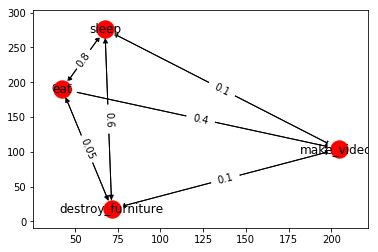

In [28]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_cat_markov.dot')

# Note: with dot installed we can view the graph using the following command
# dot -Tps pet_cat_markov.dot -o pet_cat_markov.ps

In [35]:
# assume our cat is acting weirdly relative to youtube viewership
# cat is grumpy when subscribers and viewers decline, happy otherwise
# create state space and initial state probabilities

hidden_states = ['increasing', 'decreasing']  # 
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

increasing    0.5
decreasing    0.5
Name: states, dtype: float64

 1.0


In [36]:
# create hidden transition matrix
# a or alpha 
#   = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

           increasing decreasing
increasing        0.7        0.3
decreasing        0.4        0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

increasing    1.0
decreasing    1.0
dtype: float64


In [37]:
# based on Chewbacca's behaviors, can we guess how his Youtube channel is doing?
'''
This is where it gets a little more interesting. 
Now we create the emission or observation probability matrix. 
This matrix is size M x O where M is the number of hidden states and O is the number of possible observable states. 

The emission matrix tells us the probability the dog is in one of the hidden states, 
given the current, observable state. 

Let's keep the same observable states from the previous example. 
The dog can be either sleeping, eating, or pooping. 
For now we make our best guess to fill in the probabilities. 
'''



"\nThis is where it gets a little more interesting. \nNow we create the emission or observation probability matrix. \nThis matrix is size M x O where M is the number of hidden states and O is the number of possible observable states. \n\nThe emission matrix tells us the probability the dog is in one of the hidden states, \ngiven the current, observable state. \n\nLet's keep the same observable states from the previous example. \nThe dog can be either sleeping, eating, or pooping. \nFor now we make our best guess to fill in the probabilities. \n"

In [41]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.5, 0.2, 0.05, 0.25]
b_df.loc[hidden_states[1]] = [0.2, 0.05, 0.4, 0.35]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

           sleep   eat destroy_furniture make_videos
increasing   0.5   0.2              0.05        0.25
decreasing   0.2  0.05               0.4        0.35

 [[0.5 0.2 0.05 0.25]
 [0.2 0.05 0.4 0.35]] (2, 4) 

increasing    1.0
decreasing    1.0
dtype: float64


In [42]:
# create graph edges and weights

hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('decreasing', 'decreasing'): 0.6,
 ('decreasing', 'increasing'): 0.4,
 ('increasing', 'decreasing'): 0.3,
 ('increasing', 'increasing'): 0.7}
{('decreasing', 'destroy_furniture'): 0.4,
 ('decreasing', 'eat'): 0.05,
 ('decreasing', 'make_videos'): 0.35,
 ('decreasing', 'sleep'): 0.2,
 ('increasing', 'destroy_furniture'): 0.05,
 ('increasing', 'eat'): 0.2,
 ('increasing', 'make_videos'): 0.25,
 ('increasing', 'sleep'): 0.5}


Nodes:
['increasing', 'decreasing']

Edges:
OutMultiEdgeDataView([('increasing', 'increasing', {'weight': 0.7, 'label': 0.7}), ('increasing', 'decreasing', {'weight': 0.3, 'label': 0.3}), ('increasing', 'sleep', {'weight': 0.5, 'label': 0.5}), ('increasing', 'eat', {'weight': 0.2, 'label': 0.2}), ('increasing', 'destroy_furniture', {'weight': 0.05, 'label': 0.05}), ('increasing', 'make_videos', {'weight': 0.25, 'label': 0.25}), ('decreasing', 'increasing', {'weight': 0.4, 'label': 0.4}), ('decreasing', 'decreasing', {'weight': 0.6, 'label': 0.6}), ('decreasing', 'sleep', {'weight': 0.2, 'label': 0.2}), ('decreasing', 'eat', {'weight': 0.05, 'label': 0.05}), ('decreasing', 'destroy_furniture', {'weight': 0.4, 'label': 0.4}), ('decreasing', 'make_videos', {'weight': 0.35, 'label': 0.35})])


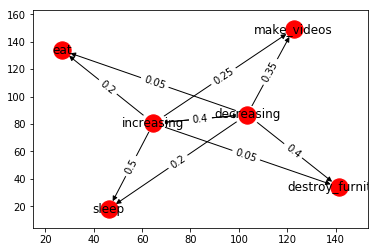

In [43]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_cat_hidden_markov.dot')

# Note: with dot installed we can view the graph using the following command
# dot -Tps pet_cat_hidden_markov.dot -o pet_cat_hidden_markov.ps

In [61]:
# Now, what if you needed to discern whether cat can pay rent by monetizing from Youtube

# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleep': 0, 'eat': 1, 'destroy_furniture': 2, 'make_videos': 3}
# obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])
obs = np.random.randint(4, size=15)

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )


   Obs_code            Obs_seq
0         0              sleep
1         0              sleep
2         3        make_videos
3         2  destroy_furniture
4         3        make_videos
5         1                eat
6         3        make_videos
7         1                eat
8         0              sleep
9         1                eat
10        3        make_videos
11        0              sleep
12        2  destroy_furniture
13        0              sleep
14        1                eat


In [62]:
# Using the Viterbi algorithm we can identify the most likely sequence of hidden 
# states given the sequence of observations.

# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]), [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

# executing the viterbi algorithm
path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 1.0
s=1 and t=4: phi[1, 4] = 1.0
s=0 and t=5: phi[0, 5] = 1.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 0.0
s=0 and t=10: phi[0, 10] = 0.0
s=1 and t=10: phi[1, 10] = 0.0
s=0 and t=11: phi[0, 11] = 0.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 0.0
s=1 and t=12: phi[1, 12] = 0.0
s=0 and t=13: phi[0, 13] = 1.0
s=1 and t=13: phi[1, 13] = 1.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0.0
path[12] = 1.0
path[11] = 0.0
path[10] = 0.0
path[9] = 0.0
path[

In [63]:
state_map = {0:'increasing', 1:'decreasing'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,sleep,increasing
1,sleep,increasing
2,make_videos,decreasing
3,destroy_furniture,decreasing
4,make_videos,decreasing
5,eat,increasing
6,make_videos,increasing
7,eat,increasing
8,sleep,increasing
9,eat,increasing
